In [1]:
import re
import sys
import json


import sys
sys.dont_write_bytecode = True
sys.path.append('../')
from datatools.analyzer import *

from datatools.maneger import DataManager
from datatools.preproc import Preprocessor

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import loss
import torch.optim as optim
import torch.nn.utils.rnn as rnn

In [3]:
path = "../hand_labeled/"
datalist = ['DCM', 'DIT', 'IRS']
convs = read_conv(path, datalist)

In [4]:

y = []
utt_list = []
errors = ["Unclear intention", "Topic transition error", "Lack of information"]
for conv in convs:
    # utt_list_conv = [""]*5
    utt_list_conv = []
    for i, ut in enumerate( conv ) :
        utt_list_conv.append(ut.utt)
        # システム発話で，[文脈-形式]のエラー
        if ut.is_system() and ut.is_exist_error():
        # if ut.is_system():
            # usr_sys.append( [conv[i-1].utt, ut.utt] )
            utt_list.append( utt_list_conv[-5:] )
            if ut.is_error_included(errors):
                y.append(1)
            else:
                y.append(0)

In [5]:
from gensim.models import KeyedVectors

w2v_path = "../../corpus/w2v/"
# fasttext
# https://qiita.com/Hironsan/items/513b9f93752ecee9e670
w2v_name =  "dep-ja-300dim"
w2v_name =  "model.vec"
w2v_model = KeyedVectors.load_word2vec_format(w2v_path+w2v_name)

In [6]:
wsv_dim = w2v_model["あ"].shape[0]
add_keys = ["FOS", "EOS", "[SEP]", "[UNK]"]
add_weights = [np.random.randn(wsv_dim) for _ in range(len(add_keys))]
add_weights = [ v/np.linalg.norm(v) for v in add_weights ]
SYMBOL_w2v = dict(zip(add_keys, add_weights))

In [7]:
symbol_path = "../models/base/"
symbol_name = "context_symbol.pickle"
symbolM = DataManager(symbol_path)
symbolM.save_data(symbol_name, SYMBOL_w2v)

success save : ../models/base/context_symbol.pickle


In [8]:


def w2v(word, w2v_model:KeyedVectors, SYMBOL_w2v:dict):
    # 形態素が登録されていたとき
    
    if word in SYMBOL_w2v:
        vector = SYMBOL_w2v[word]
    elif word in w2v_model:
        vector = w2v_model[word]
    else:
        vector = SYMBOL_w2v["[UNK]"]
    return torch.from_numpy(vector)

def sentence2formated(sen, w2v_model, SYMBOL_w2v):
    normal = sentence2morpheme(sen, sents_span=False)

    # 1文だけ
    if len(normal) < 2:
        formated =  fill_SYMBOL_ONE(normal)[0]
    else:
        normal_sep = fill_SYMBOL_SEP(normal)
        formated =  fill_SYMBOL_ONE( [sum( normal_sep, [] )] )[0]
    
    return  torch.stack( [w2v(w, w2v_model, SYMBOL_w2v) for w in formated] )


In [9]:
# ["aa", "bb"] -> ["FOS", "aa", "[SEP]", "bb", "EOS"]
sentence2formated(["aa", "bb"],  w2v_model, SYMBOL_w2v ).shape

/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  # Remove the CWD from sys.path while we load stuff.


torch.Size([5, 300])

In [10]:
from tqdm import tqdm
import torch.nn.utils.rnn as rnn

# def padding_vector(Xseq):
#     Xseq = [ torch.tensor( xseq[:, None] ) for xseq in Xseq]
#     Xseq = rnn.pad_sequence(Xseq, batch_first=True)
#     Xseq = [ torch.flatten(xseq) for xseq in Xseq ] 
#     return Xseq


def make_X(utt_list:list, w2v_model, SYMBOL_w2v):
    utt_morp_list = []
    for utt in tqdm( utt_list) :
        # ["FOS", "aa", "[SEP]", "bb", "EOS"] : 1データ
        utt_morp = sentence2formated(utt, w2v_model, SYMBOL_w2v)
        utt_morp_list.append(utt_morp)

    X = rnn.pad_sequence(utt_morp_list, batch_first=True)
    return X

In [11]:
X_= make_X(utt_list, w2v_model, SYMBOL_w2v)

100%|██████████| 992/992 [01:39<00:00,  9.93it/s]


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_, y,  test_size=0.30, random_state=5, stratify=y)

In [13]:
class Datasets(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        # self.transform = transform

        self.X_data = X_data
        self.y_data = y_data

        self.datanum = len(X_data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_X = self.X_data[idx]
        out_y = self.y_data[idx]

        return out_X, out_y

In [14]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, tagset_size, w2v_model, SYMBOL_w2v):
        # 親クラスのコンストラクタ。決まり文句
        super(LSTMClassifier, self).__init__()
        # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。    
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        # モデルを2つ定義
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim//2, batch_first=True,  bidirectional=True )
        # self.lstm2 = nn.LSTM(embedding_dim, hidden_dim//2, batch_first=True,  bidirectional=True )
        self.xtoy_2 = nn.Linear(embedding_dim*3 , hidden_dim)
        self.y3toy = nn.Linear(hidden_dim, tagset_size)
        # softmaxのLog版。dim=0で列、dim=1で行方向を確率変換。
        self.softmax = nn.LogSoftmax()
        self.tanh = nn.Tanh()
    
        self.w2v_model = w2v_model
        self.SYMBOL_w2v = SYMBOL_w2v
    
    def pooling(self, A):
        # A : dim3
        # pooled = []
        b_len = len(A)
        f_len = len(A[0][0])
        pooled = torch.zeros((b_len, f_len)).cuda()
        for i, batch in enumerate( A ):
            for j in range(f_len):
                # batch_pooled.append( A[i, torch.argmax(A[i, :, j]), j] )
                pooled[i, j] = A[i, torch.argmax(A[i, :, j]), j]
        return pooled

    def pooling_2(self, A):
        # A : dim3
        if len(A.shape) == 2:
            A = torch.stack([A])
        b_len = len(A)
        seq_len = len(A[0])
        m = nn.MaxPool1d(seq_len, stride=seq_len)
        B = A.permute((0, 2, 1))
        return m(B).reshape(b_len, -1)
    
    def forward(self, e):
        
        out, hc = self.bilstm(e)
        x = torch.cat([ out, e], dim=2 )
        y_2 = self.tanh( self.xtoy_2(x) )
        y_3 = self.pooling_2(y_2)
        y = self.softmax( self.y3toy(y_3) )
        return y

        

In [15]:
BATCH_SIZE = 32
epoch_ = 150
trainset = Datasets(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

In [16]:
# VOCAB_SIZE = len(vocab_dict)
EMBEDDING_DIM = 300
HIDDEN_DIM = EMBEDDING_DIM*2
OUTPUT_DIM = 2

In [17]:
model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, w2v_model, SYMBOL_w2v)
if torch.cuda.is_available():
   model.cuda()
loss_function = nn.NLLLoss()
# loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
losses = []
from tqdm import tqdm
for epoch in tqdm( range(epoch_) ) :  # again, normally you would NOT do 300 epochs, it is toy data
    all_loss = 0
    for data in trainloader:
        # X_t_tensor = torch.tensor(data[0], device='cuda:0', dtype=torch.int16)
        # X_tens= data[0].to(torch.int).cuda()
        # y_tens = data[1].to(torch.long).cuda()
        X_tens= data[0].float().cuda()
        y_tens = data[1].to(torch.long).cuda()
        optimizer.zero_grad()
        model.zero_grad()

        score = model(X_tens)
        # print(X_t_tensor.shape, score.view(-1,5).shape, y_t_tensor.view(-1,1).shape)
        loss_ = loss_function(score,  y_tens)
        loss_.backward()
        all_loss += loss_.item()
        optimizer.step()
        del score
        del loss_
    losses.append(all_loss)
    if (epoch+1) % 50 == 0:
        print("epoch", epoch+1, "\t" , "loss", all_loss)
print("done")

 33%|███▎      | 50/150 [03:13<06:38,  3.99s/it]

epoch 50 	 loss 0.028828886861447245


 67%|██████▋   | 100/150 [06:31<03:15,  3.92s/it]

epoch 100 	 loss 0.0007466417991963681


100%|██████████| 150/150 [09:51<00:00,  3.94s/it]

epoch 150 	 loss 0.00015119953923203866
done


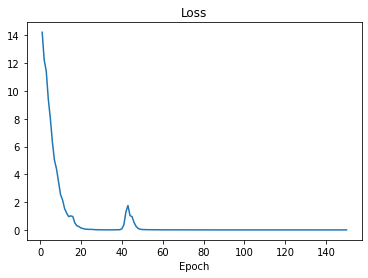

In [19]:
from matplotlib import pyplot as plt
def plot_history(losses):
    fig, ax = plt.subplots()

    epochs = np.arange(1, len(losses) + 1)

    # 損失の推移
    ax.set_title("Loss")
    ax.plot(epochs, losses)
    ax.set_xlabel("Epoch")

    plt.show()
plot_history(losses)

In [20]:
with torch.no_grad():
    X_tensor = torch.tensor(X_test, device='cuda:0').float()
    y_tensor = torch.tensor(y_test, device='cuda:0', dtype=torch.long)
            # 推論
    y_pred= np.array(model(X_tensor).cpu()).argmax(axis=1)

/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [21]:
print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred))
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred))
print('precision = ', precision_score(y_true=y_test, y_pred=y_pred))
print('recall = ', recall_score(y_true=y_test, y_pred=y_pred))
print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred))

confusion matrix = 
 [[ 49  57]
 [ 33 159]]
accuracy =  0.697986577181208
precision =  0.7361111111111112
recall =  0.828125
f1 score =  0.7794117647058824


In [22]:
model_path = "../models/base/"
model_name = "context_form.pickle"
modelM = DataManager(model_path)
modelM.save_data(model_name, model)

success save : ../models/base/context_form.pickle


In [23]:
A = torch.arange(60).view(5, 3, -1)

In [24]:
def pooling(A):
    # A : dim3
    # pooled = []
    b_len = len(A)
    f_len = len(A[0][0])
    pooled = torch.zeros((b_len, f_len))
    for i, batch in enumerate( A ):
        for j in range(f_len):
            # batch_pooled.append( A[i, torch.argmax(A[i, :, j]), j] )
            pooled[i, j] = A[i, torch.argmax(A[i, :, j]), j]
    return pooled

In [25]:
pooled = []
f_len = len(A[0][0])
for i, batch in enumerate( A ):
    batch_pooled = []
    for j in range(f_len):
        batch_pooled.append( A[i, torch.argmax(A[i, :, j]), j] )
    # pooled.append(torch.stack(batch_pooled))
    pooled.append(batch_pooled)
A_ = pooled 
A_

[[tensor(8), tensor(9), tensor(10), tensor(11)],
 [tensor(20), tensor(21), tensor(22), tensor(23)],
 [tensor(32), tensor(33), tensor(34), tensor(35)],
 [tensor(44), tensor(45), tensor(46), tensor(47)],
 [tensor(56), tensor(57), tensor(58), tensor(59)]]

In [26]:
A[0][2][0] = 30


In [27]:
A

tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [30,  9, 10, 11]],

        [[12, 13, 14, 15],
         [16, 17, 18, 19],
         [20, 21, 22, 23]],

        [[24, 25, 26, 27],
         [28, 29, 30, 31],
         [32, 33, 34, 35]],

        [[36, 37, 38, 39],
         [40, 41, 42, 43],
         [44, 45, 46, 47]],

        [[48, 49, 50, 51],
         [52, 53, 54, 55],
         [56, 57, 58, 59]]])

In [28]:
A_

[[tensor(30), tensor(9), tensor(10), tensor(11)],
 [tensor(20), tensor(21), tensor(22), tensor(23)],
 [tensor(32), tensor(33), tensor(34), tensor(35)],
 [tensor(44), tensor(45), tensor(46), tensor(47)],
 [tensor(56), tensor(57), tensor(58), tensor(59)]]

In [29]:
A2 = torch.tensor(A_)

In [30]:
A[1][2][0] = 60


In [31]:
A2

tensor([[30,  9, 10, 11],
        [20, 21, 22, 23],
        [32, 33, 34, 35],
        [44, 45, 46, 47],
        [56, 57, 58, 59]])

In [32]:
A_

[[tensor(30), tensor(9), tensor(10), tensor(11)],
 [tensor(60), tensor(21), tensor(22), tensor(23)],
 [tensor(32), tensor(33), tensor(34), tensor(35)],
 [tensor(44), tensor(45), tensor(46), tensor(47)],
 [tensor(56), tensor(57), tensor(58), tensor(59)]]